# Seq2Vec Sentiment Modeling in Tensorflow

## 1.0 - Import Packages

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd
from sklearn.metrics import mean_absolute_error
from keras import backend as K
from keras.layers import Dropout
import os
import numpy as np
import seaborn as sns
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *

/opt/conda/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
CUR_DIR = os.path.abspath(os.curdir)
ROOT_DIR = os.path.dirname(CUR_DIR)
IMAGES_DIR = os.path.join(ROOT_DIR, "images")
DATA_DIR = os.path.join(ROOT_DIR, "data")
MODELS_DIR = os.path.join(ROOT_DIR, "models")
EVAL_DIR = os.path.join(ROOT_DIR, "evaluation")
MODEL_PERF_DIR = os.path.join(EVAL_DIR, "model_performance")
GRAPHS_DIR = os.path.join(EVAL_DIR, "graphs")
writepath = os.path.join(MODEL_PERF_DIR, "performance.csv")

## 1.1 Import Data 

In [3]:
validation_df = pd.read_csv(os.path.join(DATA_DIR,'raw','validation.csv'))
training_df = pd.read_csv(os.path.join(DATA_DIR,'raw','training.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR,'raw','test.csv'))

X_train = training_df['review']
y_train = training_df['star']

X_val = validation_df['review']
y_val = validation_df['star']

X_test = test_df['review']
y_test = test_df['star']

# Convert to tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(buffer_size=1024).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(buffer_size=1024).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(buffer_size=1024).batch(128)

2022-03-16 05:59:28.110333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-16 05:59:28.110498: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-16 05:59:28.110609: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42b10f96906e): /proc/driver/nvidia/version does not exist
2022-03-16 05:59:28.111335: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2.0 Create embedding layer & Build simple model

In [4]:
handle = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1'

emb_layer = hub.KerasLayer(handle = handle, output_shape=(20,1),
               input_shape=(None,),dtype=tf.string,trainable=True, name='embed')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

2022-03-16 05:59:28.303217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [5]:
embed = hub.load(handle)
embeddings = embed(["man","woman"])
embeddings

<tf.Tensor: shape=(2, 20), dtype=float32, numpy=
array([[ 3.9687425e-01, -6.3695002e-01, -6.7363518e-01, -1.3100165e-01,
         5.2906036e-01,  2.3391739e-01, -1.7667708e-01,  1.0469885e+00,
         1.5244880e+00,  8.3604610e-01, -7.9439002e-01,  1.0453002e-01,
        -2.2940248e-02, -1.4738902e-01, -8.3987337e-01,  1.0697368e+00,
        -4.5744944e-01, -4.4647139e-01, -1.3669002e+00,  1.6243970e-01],
       [ 4.5780963e-01, -6.5106559e-01, -4.7487444e-01, -1.3545550e-01,
         7.5560737e-01,  1.3068053e-01, -2.7652311e-01,  1.2009813e+00,
         1.6298714e+00,  1.1437336e+00, -6.3142008e-01,  6.7427382e-04,
        -3.1341049e-01, -2.5012997e-01, -8.7322730e-01,  7.1451533e-01,
        -4.2308569e-01, -7.8139108e-01, -1.1334857e+00,  1.6536513e-01]],
      dtype=float32)>

## Baseline

In [6]:
epochs = 100

base_model = keras.Sequential([
        layers.Input(shape=(), name="Input", dtype=tf.string),
        emb_layer,
        layers.Dense(10,activation='relu', dtype=tf.float32),
        layers.Dense(1,activation=relu_advanced)],name='2.0-Base-No-Reg-Swivel')

base_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=keras.optimizers.Adam(lr=0.0003,decay=1e-6),
                   metrics=['mae'])


base_history = base_model.fit(train_ds,
                    epochs = epochs,
                    validation_data=val_ds,
                    callbacks=[callback],
                    verbose=1)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
1351/1351 [==============================] - 11s 8ms/step - loss: 3.7451 - mae: 1.4533 - val_loss: 2.1753 - val_mae: 1.0125
Epoch 2/100
1351/1351 [==============================] - 18s 13ms/step - loss: 1.9178 - mae: 0.9189 - val_loss: 1.7435 - val_mae: 0.8709
Epoch 3/100
1351/1351 [==============================] - 24s 18ms/step - loss: 1.6295 - mae: 0.8372 - val_loss: 1.5526 - val_mae: 0.8226
Epoch 4/100
1351/1351 [==============================] - 22s 17ms/step - loss: 1.4719 - mae: 0.7974 - val_loss: 1.4440 - val_mae: 0.7975
Epoch 5/100
1351/1351 [==============================] - 16s 12ms/step - loss: 1.3753 - mae: 0.7722 - val_loss: 1.3786 - val_mae: 0.7777
Epoch 6/100
1351/1351 [==============================] - 19s 14ms/step - loss: 1.3134 - mae: 0.7553 - val_loss: 1.3376 - val_mae: 0.7697
Epoch 7/100
1351/1351 [==============================] - 23s 17ms/step - loss: 1.2707 - mae: 0.7438 - val_loss: 1.3106 - val_mae: 0.7639
Epoch 8/100
1351/1351 [===================

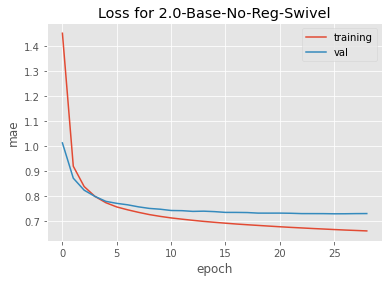

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-Base-No-Reg-Swivel.png


In [7]:
plot_loss(base_history,base_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.7160536684428862


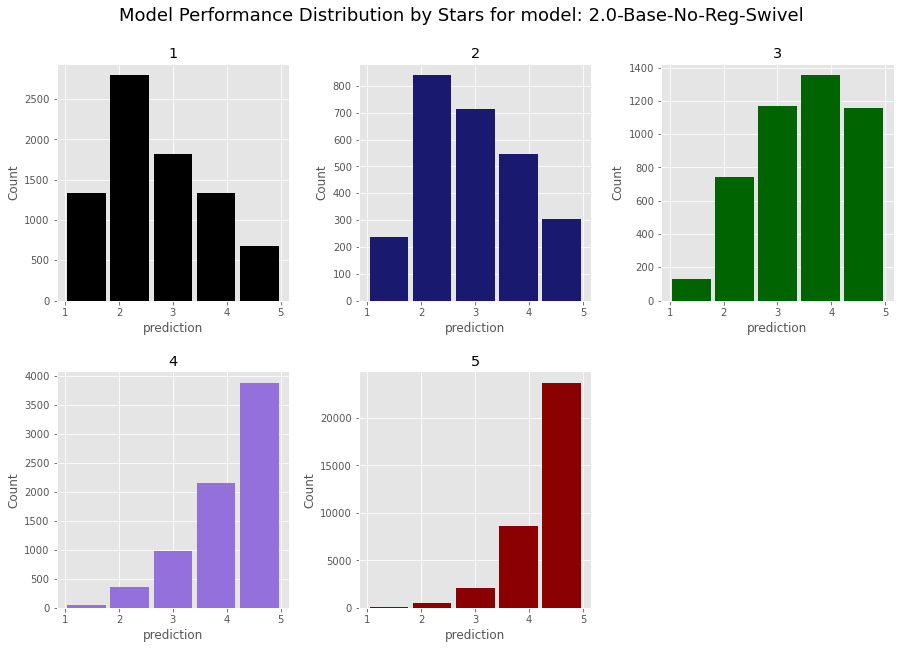

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


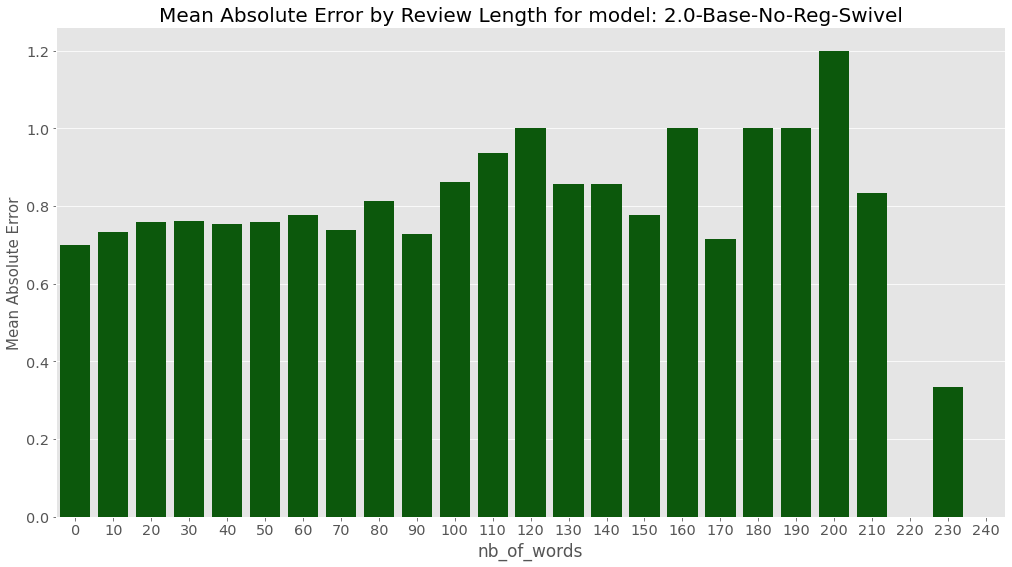

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.73      0.17      0.27      7964
           2       0.16      0.32      0.21      2640
           3       0.17      0.26      0.21      4548
           4       0.15      0.29      0.20      7414
           5       0.80      0.68      0.73     35047

    accuracy                           0.51     57613
   macro avg       0.40      0.34      0.32     57613
weighted avg       0.63      0.51      0.53     57613

"I like the top but it took long to deliver" receives a score of [3.0487115]
"This app is trash" receives a score of [1.4346969]
"The app is extremely slow, but I still like it" receives a score of [2.8118987]
"I Do not Love this App" receives a score of [5.]
"Too many glitches" receives a score of [2.06979]
"Worthless app" receives a score of [3.974592]
"Do not download this app" receives a score of [2.2405572]
"Horrible" receives a score of [3.8295557]
"Could be better 

In [8]:
performance_evaluation(X_test, y_test, base_model)

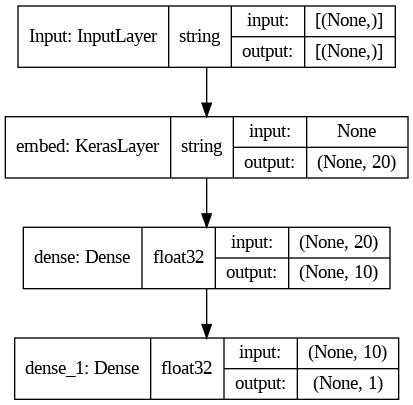

In [9]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{base_model.name}.png')
tf.keras.utils.plot_model(base_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [10]:
base_model.save(os.path.join(MODELS_DIR,base_model.name))

2022-03-16 06:11:44.534857: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-Base-No-Reg-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-Base-No-Reg-Swivel/assets


## RNN

In [11]:
embed
embed(X_train).shape

TensorShape([172839, 20])

In [12]:
rnn_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.SimpleRNN(2, activation='tanh',return_sequences=False),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-RNN-No-Reg-Swivel')

rnn_model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

num_epochs=100
rnn_history=rnn_model.fit(train_ds, 
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 55s 38ms/step - loss: 6.3533 - mae: 2.2015 - val_loss: 2.6097 - val_mae: 1.4254
Epoch 2/100
1351/1351 [==============================] - 60s 45ms/step - loss: 2.3284 - mae: 1.2664 - val_loss: 2.1155 - val_mae: 1.1830
Epoch 3/100
1351/1351 [==============================] - 59s 44ms/step - loss: 1.7293 - mae: 1.0406 - val_loss: 1.5427 - val_mae: 0.9448
Epoch 4/100
1351/1351 [==============================] - 49s 36ms/step - loss: 1.4423 - mae: 0.8987 - val_loss: 1.4170 - val_mae: 0.8819
Epoch 5/100
1351/1351 [==============================] - 47s 35ms/step - loss: 1.3233 - mae: 0.8497 - val_loss: 1.3253 - val_mae: 0.8465
Epoch 6/100
1351/1351 [==============================] - 47s 35ms/step - loss: 1.2523 - mae: 0.8228 - val_loss: 1.2903 - val_mae: 0.8310
Epoch 7/100
1351/1351 [==============================] - 56s 41ms/step - loss: 1.2145 - mae: 0.8067 - val_loss: 1.2711 - val_mae: 0.8211
Epoch 8/100
1351/1351 [==================

In [13]:
rnn_model.summary()

Model: "2.0-RNN-No-Reg-Swivel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (KerasLayer)           (None, 20)                389380    
_________________________________________________________________
reshape (Reshape)            (None, 20, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2)                 8         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 389,391
Trainable params: 389,391
Non-trainable params: 0
_________________________________________________________________


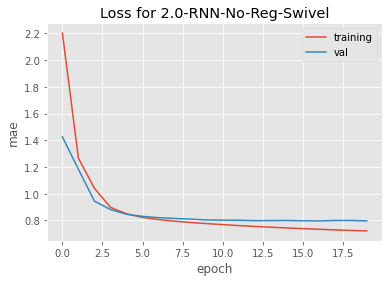

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-RNN-No-Reg-Swivel.png


In [14]:
plot_loss(rnn_history,rnn_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.732143786992519


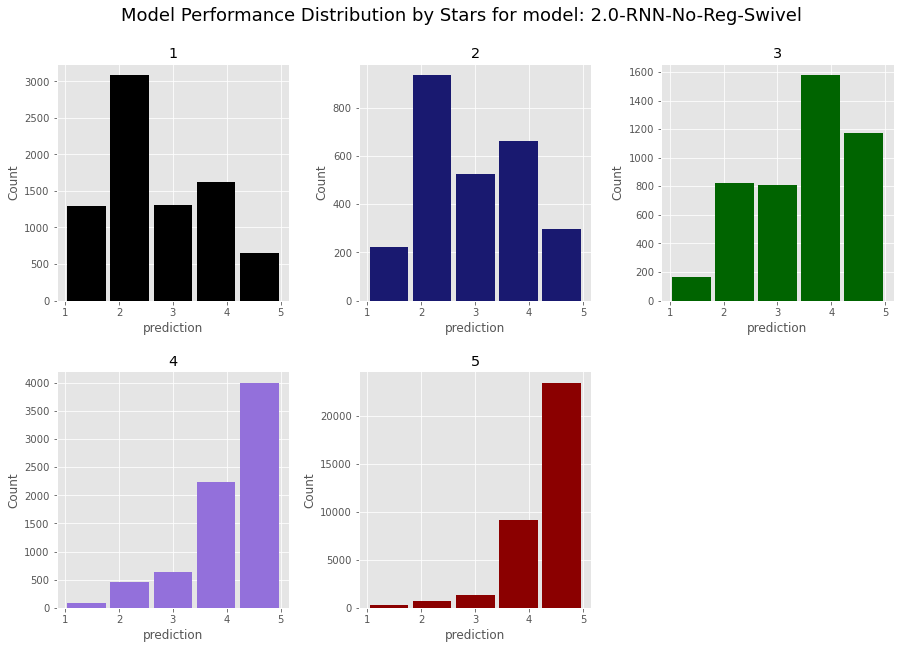

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


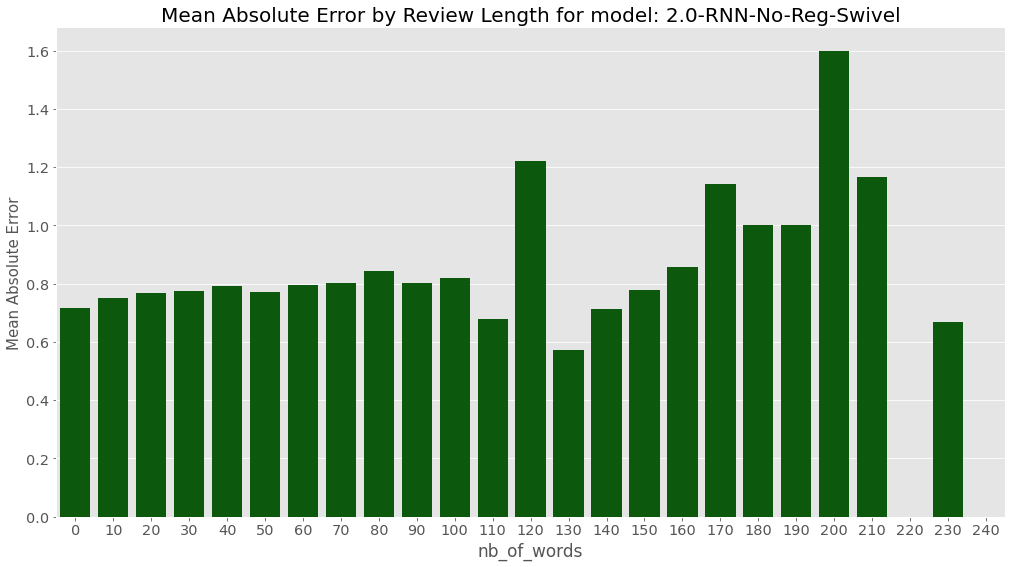

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.64      0.16      0.26      7964
           2       0.15      0.35      0.22      2640
           3       0.18      0.18      0.18      4548
           4       0.15      0.30      0.20      7414
           5       0.79      0.67      0.73     35047

    accuracy                           0.50     57613
   macro avg       0.38      0.33      0.31     57613
weighted avg       0.61      0.50      0.53     57613

"I like the top but it took long to deliver" receives a score of [4.3103952]
"This app is trash" receives a score of [1.1304259]
"The app is extremely slow, but I still like it" receives a score of [2.8058648]
"I Do not Love this App" receives a score of [4.7598133]
"Too many glitches" receives a score of [2.2193227]
"Worthless app" receives a score of [4.2537756]
"Do not download this app" receives a score of [2.0796165]
"Horrible" receives a score of [3.8223612]
"Could 

In [15]:
performance_evaluation(X_test, y_test, rnn_model)

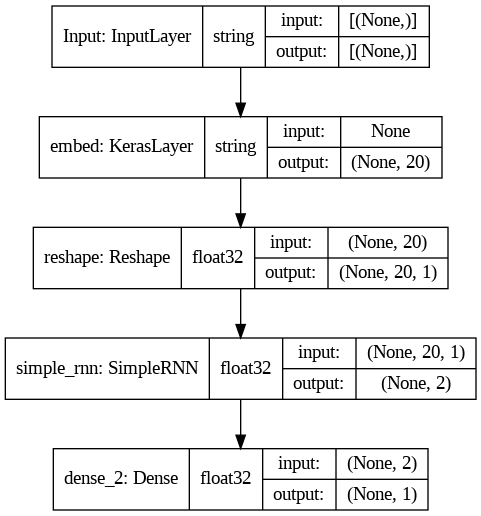

In [16]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{rnn_model.name}.png')
tf.keras.utils.plot_model(rnn_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [17]:
rnn_model.save(os.path.join(MODELS_DIR,rnn_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-RNN-No-Reg-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-RNN-No-Reg-Swivel/assets


In [18]:
# max(y_pred)

In [19]:
gru_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.GRU(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-GRU-No-Reg-Swivel')
gru_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

num_epochs=100
gru_history=gru_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 63s 42ms/step - loss: 2.6080 - mae: 1.2508 - val_loss: 1.2420 - val_mae: 0.8117
Epoch 2/100
1351/1351 [==============================] - 57s 42ms/step - loss: 1.1200 - mae: 0.7682 - val_loss: 1.2330 - val_mae: 0.7994
Epoch 3/100
1351/1351 [==============================] - 52s 38ms/step - loss: 1.0594 - mae: 0.7374 - val_loss: 1.2494 - val_mae: 0.7967
Epoch 4/100
1351/1351 [==============================] - 57s 42ms/step - loss: 1.0331 - mae: 0.7232 - val_loss: 1.2609 - val_mae: 0.7944
Epoch 5/100
1351/1351 [==============================] - 56s 41ms/step - loss: 1.0150 - mae: 0.7134 - val_loss: 1.2756 - val_mae: 0.7894
Epoch 6/100
1351/1351 [==============================] - 58s 43ms/step - loss: 1.0001 - mae: 0.7055 - val_loss: 1.2869 - val_mae: 0.7933
Epoch 7/100
1351/1351 [==============================] - 60s 45ms/step - loss: 0.9830 - mae: 0.6965 - val_loss: 1.2952 - val_mae: 0.7874
Epoch 8/100
1351/1351 [==================

In [20]:
gru_model.save(os.path.join(MODELS_DIR,gru_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-GRU-No-Reg-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-GRU-No-Reg-Swivel/assets


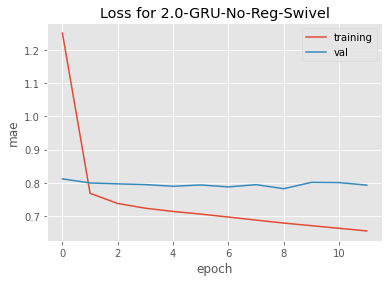

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-GRU-No-Reg-Swivel.png


In [21]:
plot_loss(gru_history,gru_model)

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.7251141235485047


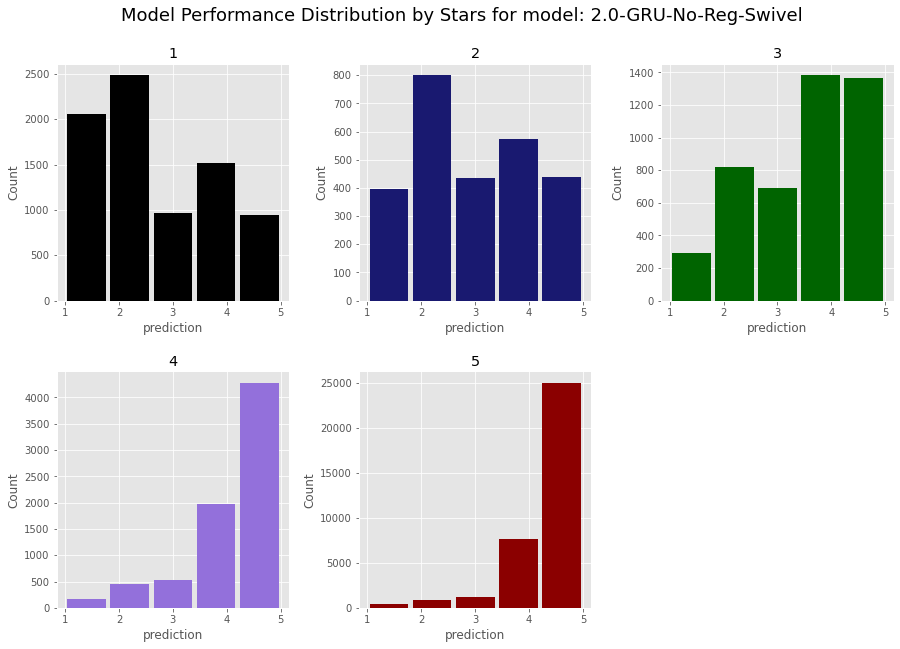

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


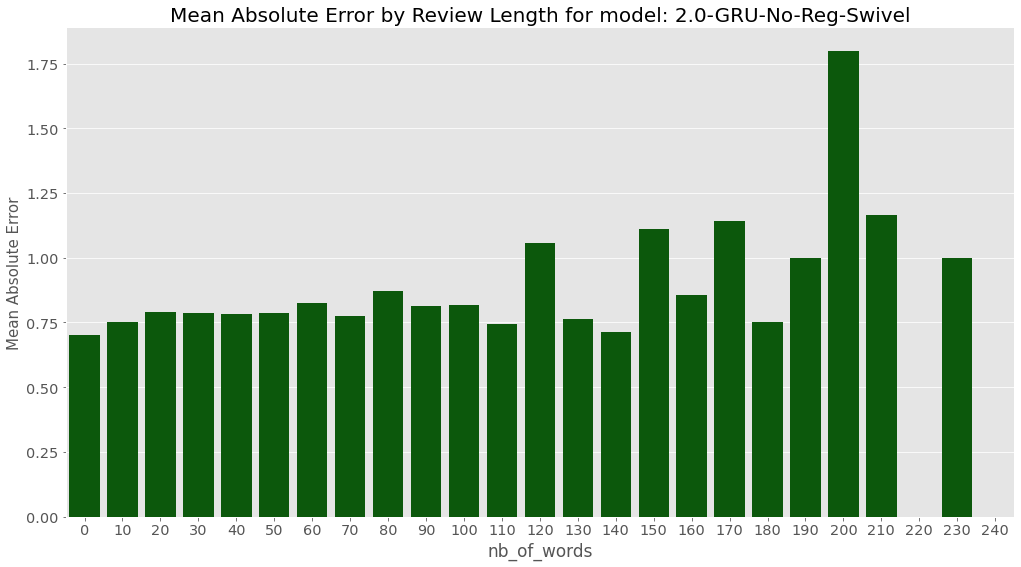

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.62      0.26      0.37      7964
           2       0.15      0.30      0.20      2640
           3       0.18      0.15      0.16      4548
           4       0.15      0.27      0.19      7414
           5       0.78      0.71      0.75     35047

    accuracy                           0.53     57613
   macro avg       0.38      0.34      0.33     57613
weighted avg       0.60      0.53      0.55     57613

"I like the top but it took long to deliver" receives a score of [4.2811728]
"This app is trash" receives a score of [1.049309]
"The app is extremely slow, but I still like it" receives a score of [2.0577037]
"I Do not Love this App" receives a score of [4.5991316]
"Too many glitches" receives a score of [2.7996545]
"Worthless app" receives a score of [4.6125116]
"Do not download this app" receives a score of [1.8439227]
"Horrible" receives a score of [4.0211854]
"Could b

In [22]:
performance_evaluation(X_test, y_test, gru_model)

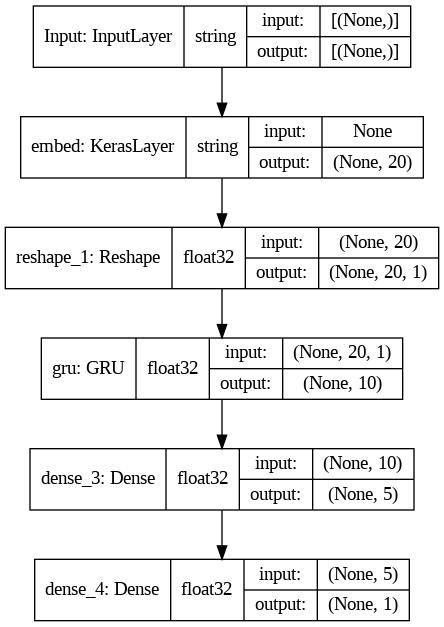

In [23]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{gru_model.name}.png')
tf.keras.utils.plot_model(gru_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## LSTM

In [24]:
lstm_model = tf.keras.Sequential([
    layers.Input(shape=(), name="Input", dtype=tf.string),
    emb_layer,
    layers.Reshape(target_shape= (20,1)),
    layers.LSTM(10, activation='tanh',return_sequences=False),
    layers.Dense(5,activation='tanh'),
    layers.Dense(1,activation=relu_advanced)
],name='2.0-LSTM-No-Reg-Swivel')
lstm_model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mae'])

num_epochs=100
lstm_history=lstm_model.fit(train_ds,
                          epochs=num_epochs, 
                          validation_data = val_ds, 
                          callbacks=[callback],
                          verbose=1)

Epoch 1/100
1351/1351 [==============================] - 52s 35ms/step - loss: 3.0111 - mae: 1.3976 - val_loss: 1.2456 - val_mae: 0.8406
Epoch 2/100
1351/1351 [==============================] - 55s 41ms/step - loss: 1.1305 - mae: 0.7726 - val_loss: 1.2059 - val_mae: 0.7869
Epoch 3/100
1351/1351 [==============================] - 62s 46ms/step - loss: 1.0858 - mae: 0.7445 - val_loss: 1.1999 - val_mae: 0.7702
Epoch 4/100
1351/1351 [==============================] - 62s 46ms/step - loss: 1.0569 - mae: 0.7285 - val_loss: 1.2001 - val_mae: 0.7663
Epoch 5/100
1351/1351 [==============================] - 57s 42ms/step - loss: 1.0320 - mae: 0.7147 - val_loss: 1.2070 - val_mae: 0.7643
Epoch 6/100
1351/1351 [==============================] - 54s 40ms/step - loss: 1.0076 - mae: 0.7020 - val_loss: 1.2144 - val_mae: 0.7523
Epoch 7/100
1351/1351 [==============================] - 54s 40ms/step - loss: 0.9834 - mae: 0.6895 - val_loss: 1.2209 - val_mae: 0.7556
Epoch 8/100
1351/1351 [==================

The prediction values range between [1.] and [5.]
Mean Absolute Error: 0.7069411417562008


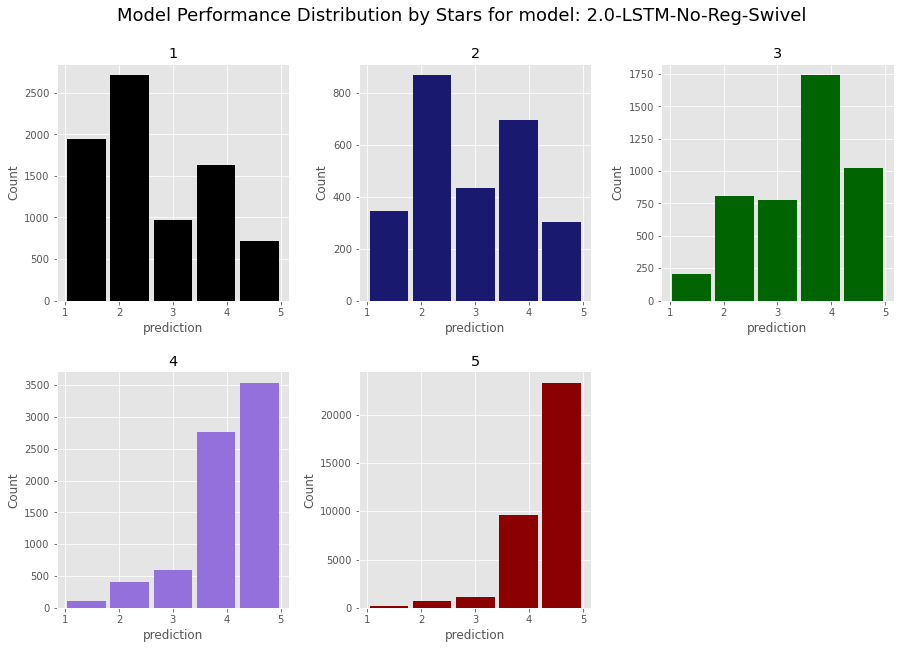

/home/jovyan/projects/vector-nlp/src/utils.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_df[bin_field_name] = pd.cut(eval_df[field], bins=bins, labels=labels)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


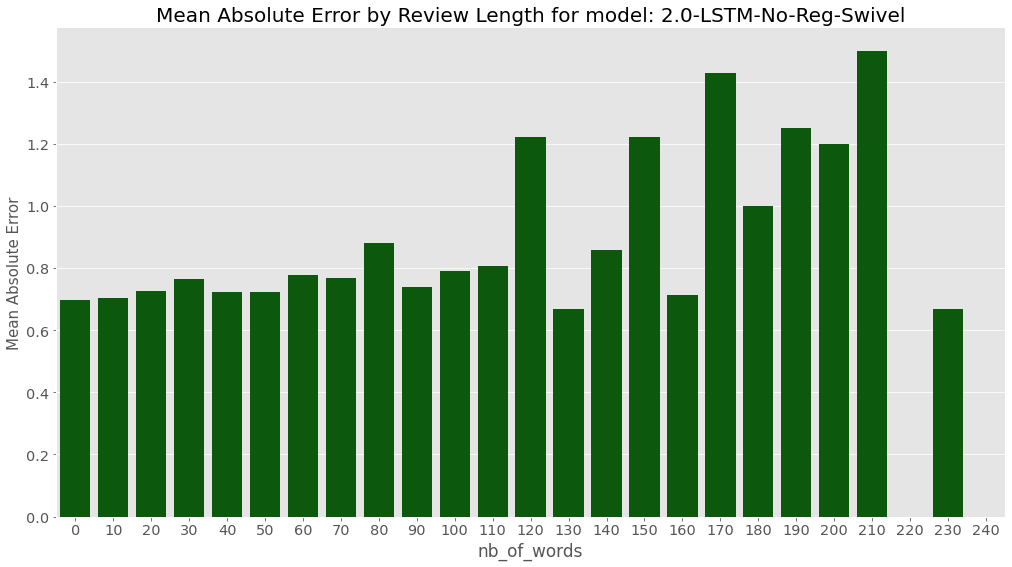

Performance appended successfully.
              precision    recall  f1-score   support

           1       0.69      0.24      0.36      7964
           2       0.16      0.33      0.21      2640
           3       0.20      0.17      0.18      4548
           4       0.17      0.37      0.23      7414
           5       0.81      0.67      0.73     35047

    accuracy                           0.51     57613
   macro avg       0.40      0.36      0.34     57613
weighted avg       0.63      0.51      0.55     57613

"I like the top but it took long to deliver" receives a score of [3.0972996]
"This app is trash" receives a score of [0.53107834]
"The app is extremely slow, but I still like it" receives a score of [2.77531]
"I Do not Love this App" receives a score of [4.704414]
"Too many glitches" receives a score of [2.5298994]
"Worthless app" receives a score of [4.2321396]
"Do not download this app" receives a score of [1.9604971]
"Horrible" receives a score of [4.1564727]
"Could be

In [25]:
performance_evaluation(X_test, y_test, lstm_model)

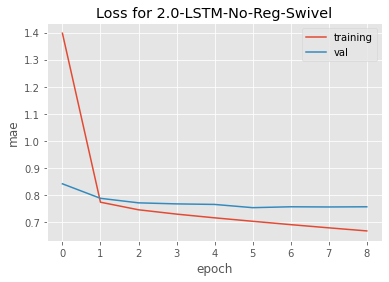

/home/jovyan/projects/vector-nlp/evaluation/graphs/Loss Plot 2.0-LSTM-No-Reg-Swivel.png


In [26]:
plot_loss(lstm_history,lstm_model)

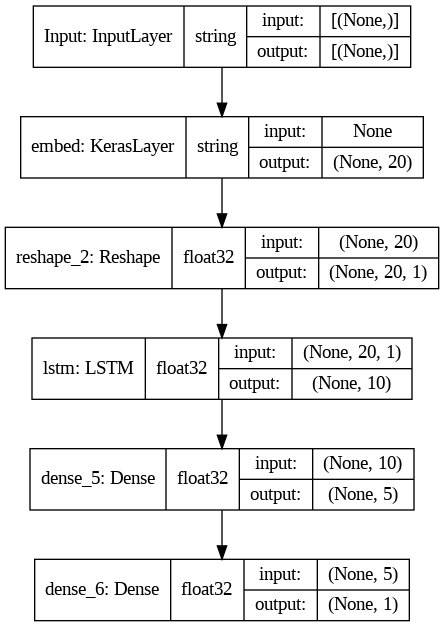

In [27]:
plot_model_path = os.path.join(IMAGES_DIR, f'plot_model_{lstm_model.name}.png')
tf.keras.utils.plot_model(lstm_model, to_file=plot_model_path ,show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [28]:
lstm_model.save(os.path.join(MODELS_DIR,lstm_model.name))

INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-LSTM-No-Reg-Swivel/assets


INFO:tensorflow:Assets written to: /home/jovyan/projects/vector-nlp/models/2.0-LSTM-No-Reg-Swivel/assets
